In [1]:
import symnum
import symnum.numpy as snp
import sympy
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [3]:
# x[0]: extended space (rough), x[1]: momentum, x[2]:position
# unit mass (M = 1) 

def drift_position(x, θ):
    return snp.array([x[1]])

def drift_momentum(x, θ):
    λ, *_ = θ
    # the potential function q -> V(q) is assumed to be V(q) = q^2 /2 
    return snp.array([- x[2] + λ*x[0]])

def diff_coeff_rough(x, θ):
    *_, α, β = θ
    σ = snp.sqrt(2*α/β)
    return snp.array([[σ]])

def drift_rough(x, θ):
    λ, α, *_ = θ
    return snp.array([- λ*x[1] - α*x[0]])

def drift_smooth(x, θ):
    return snp.concatenate((drift_momentum(x, θ), drift_position(x, θ)))

def drift_func(x, θ):
    return snp.concatenate((drift_rough(x, θ), drift_smooth(x, θ)))

def diff_coeff(x, θ):
    *_, α, β = θ
    σ = snp.sqrt(2*α/β)
    return snp.array([[σ], [0], [0]])
    
dim_x = 3
dim_s1 = 1
dim_s2 = 1
dim_r = 1
dim_θ = 3
dim_w = 1

Text(0.5, 0, 'Time')

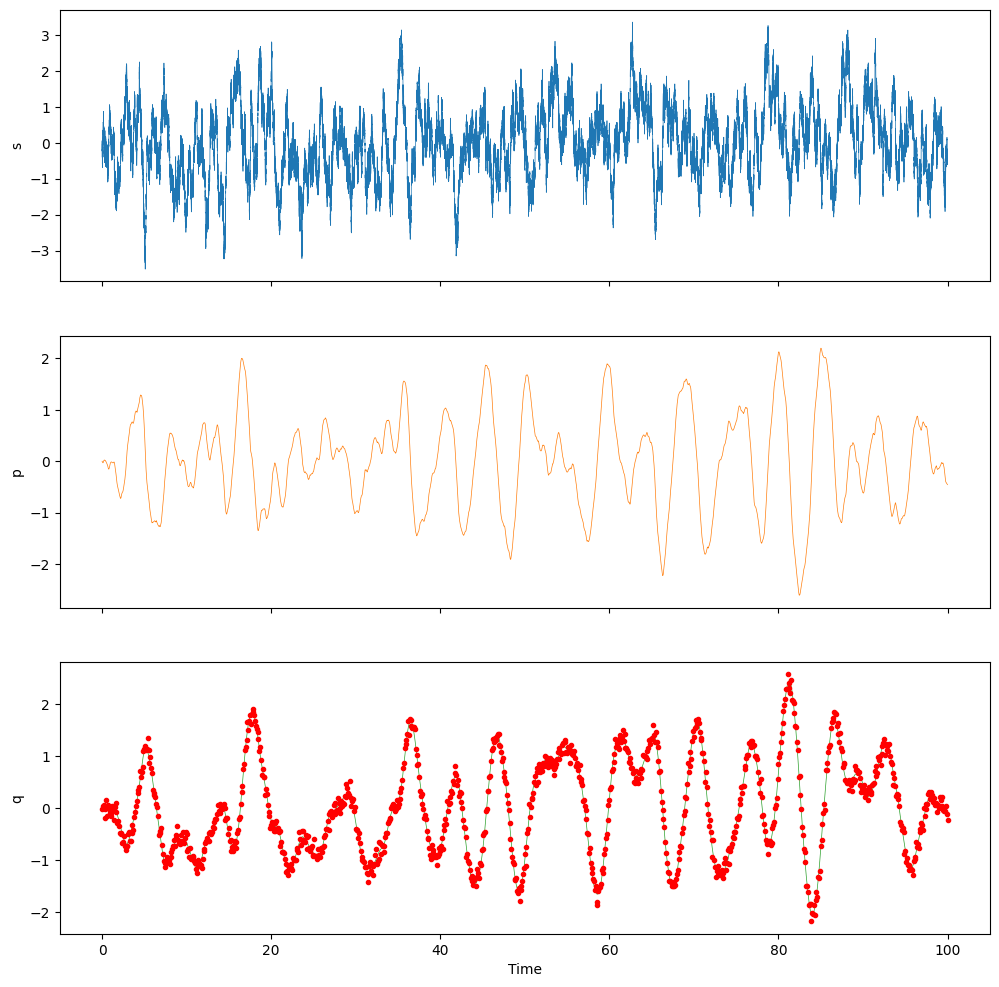

In [27]:
dim_u = 3
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [ 
            jnp.exp(u[0]),  # λ
            jnp.exp(u[1]),  # α
            jnp.exp(u[2]),  # β
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([0.00, 0.00, 0.00])
    
def obs_func(x_seq):
    return (x_seq[:, 2])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"λ": θ[0], "α": θ[1], "β": θ[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500): # -500 is default

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_r
    ),
    "local_gaussian_ii": (
        simsde.integrators.hypoelliptic_ii_local_gaussian_step(drift_func, drift_rough, drift_position, drift_momentum, diff_coeff_rough),
        3*dim_r
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 1e-4
t_max = 100.
dt_observation = 0.1
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

simulation_method = "local_gaussian_ii"
#simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221111)
obs_noise_std = 0.1
x_0_obs = np.array([0.0, 0.0, 0.0])
θ_obs = np.array([1.0, 2.0, 1.0])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'spq' # s: extended variable (rough component), p: momentum, q: position
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, x_seq_obs[:, i], color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[2].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama
0.02


Sampling stage: Adaptive warm up [13:18] > Main non-adaptive [10:43]

Chain 1/4: 100%|██████████|500/500 [00:00<00:00, 633.78it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [03:34<00:00, 2.34it/s, n_step=1.02e+03, accept_stat=0.933]

Chain 3/4: 100%|██████████|500/500 [03:34<00:00, 2.33it/s, n_step=1.02e+03, accept_stat=0.937]

Chain 4/4: 100%|██████████|500/500 [03:34<00:00, 2.33it/s, n_step=1.02e+03, accept_stat=0.937]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,2.761,2.993,0.887,7.941,1.484,1.136,7.0,815.0,1.54
α,1.350,0.790,0.169,2.411,0.340,0.255,8.0,4.0,1.53
β,1.627,0.754,0.854,2.876,0.359,0.281,7.0,898.0,1.53


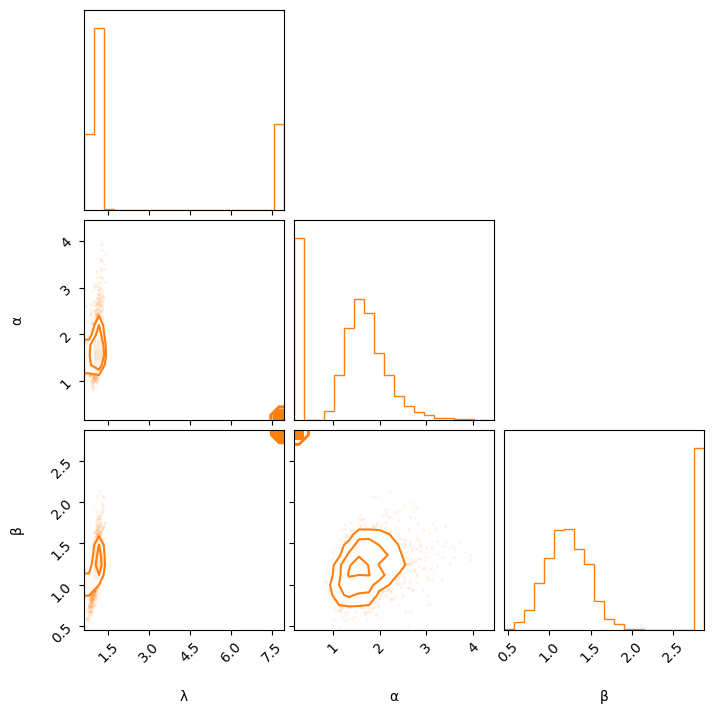

local_gaussian_ii
0.02


Sampling stage: Adaptive warm up [19:35] > Main non-adaptive [15:57]

Chain 1/4: 100%|██████████|500/500 [00:00<00:00, 547.83it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [05:18<00:00, 1.57it/s, n_step=1.02e+03, accept_stat=0.935]

Chain 3/4: 100%|██████████|500/500 [05:18<00:00, 1.57it/s, n_step=1.02e+03, accept_stat=0.935]

Chain 4/4: 100%|██████████|500/500 [05:18<00:00, 1.57it/s, n_step=1.02e+03, accept_stat=0.946]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,2.734,3.007,0.861,7.938,1.491,1.141,7.0,671.0,1.53
α,1.306,0.747,0.169,2.289,0.328,0.246,7.0,4.0,1.53
β,1.558,0.788,0.809,2.876,0.379,0.295,7.0,915.0,1.53


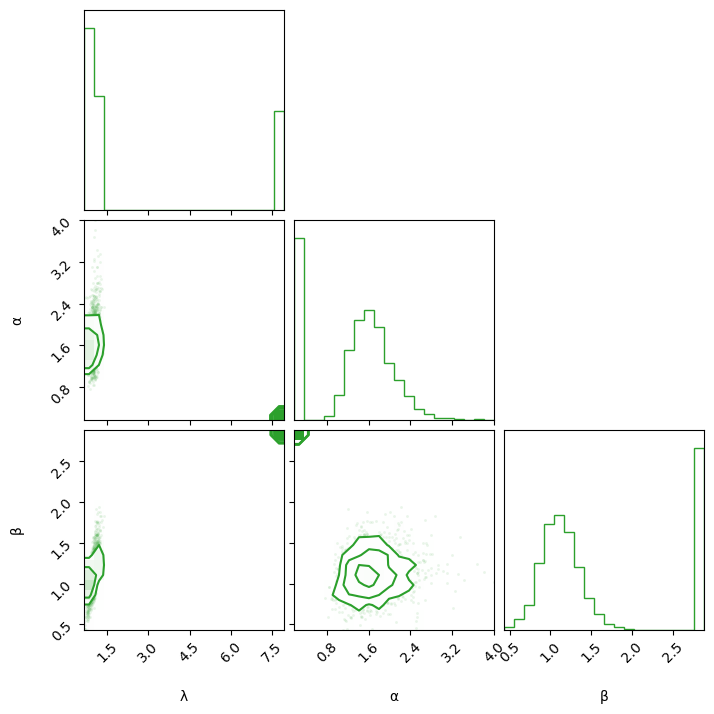

euler_maruyama
0.01


Sampling stage: Adaptive warm up [23:24] > Main non-adaptive [19:01]

Chain 1/4: 100%|██████████|500/500 [00:00<00:00, 520.56it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [06:20<00:00, 1.31it/s, n_step=1.02e+03, accept_stat=0.939]

Chain 3/4: 100%|██████████|500/500 [06:19<00:00, 1.32it/s, n_step=1.02e+03, accept_stat=0.940]

Chain 4/4: 100%|██████████|500/500 [06:20<00:00, 1.32it/s, n_step=1.02e+03, accept_stat=0.940]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,2.753,3.012,0.869,7.967,1.493,1.143,7.0,395.0,1.54
α,1.346,0.783,0.169,2.396,0.341,0.256,7.0,4.0,1.54
β,1.577,0.780,0.799,2.876,0.373,0.292,7.0,689.0,1.54


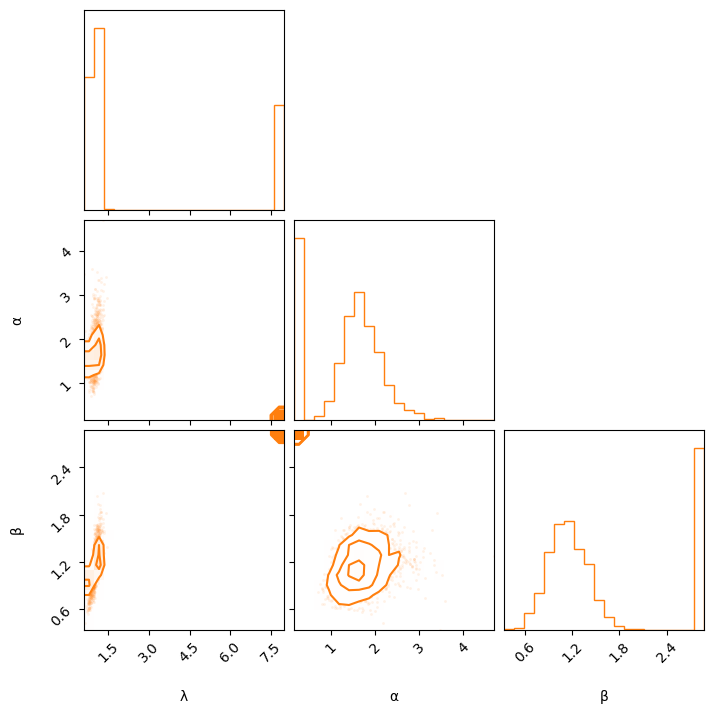

local_gaussian_ii
0.01


Sampling stage: Adaptive warm up [35:56] > Main non-adaptive [29:33]

Chain 1/4: 100%|██████████|500/500 [00:01<00:00, 402.95it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [09:51<00:00, 1.18s/it, n_step=1.02e+03, accept_stat=0.938]

Chain 3/4: 100%|██████████|500/500 [09:52<00:00, 1.18s/it, n_step=1.02e+03, accept_stat=0.940]

Chain 4/4: 100%|██████████|500/500 [09:48<00:00, 1.18s/it, n_step=1.02e+03, accept_stat=0.940]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,2.748,3.013,0.875,7.963,1.494,1.143,7.0,830.0,1.53
α,1.301,0.750,0.169,2.314,0.325,0.244,8.0,4.0,1.53
β,1.558,0.787,0.807,2.876,0.379,0.295,7.0,747.0,1.53


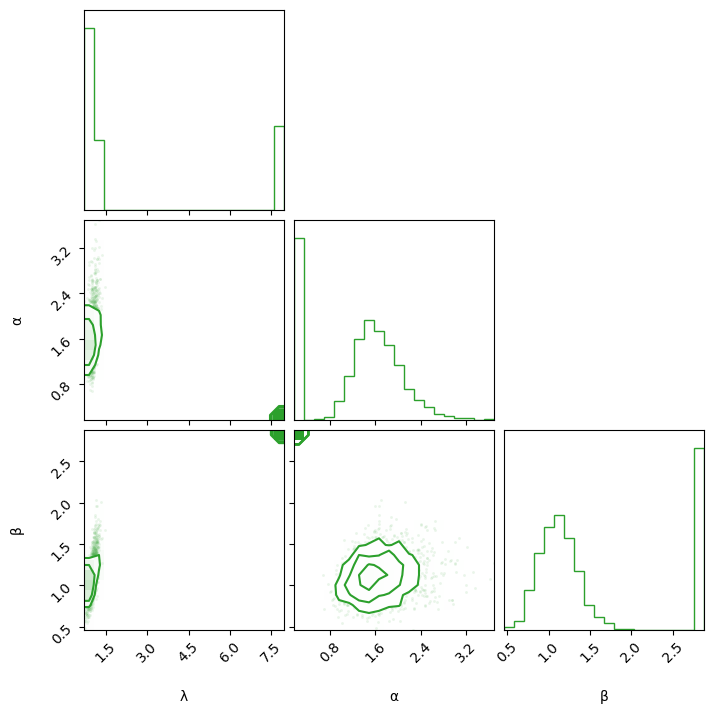

euler_maruyama
0.005


Sampling stage: Adaptive warm up [44:49] > Main non-adaptive [36:13]

Chain 1/4: 100%|██████████|500/500 [00:01<00:00, 368.39it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [12:06<00:00, 1.45s/it, n_step=1.02e+03, accept_stat=0.941]

Chain 3/4: 100%|██████████|500/500 [12:06<00:00, 1.45s/it, n_step=1.02e+03, accept_stat=0.932]

Chain 4/4: 100%|██████████|500/500 [11:59<00:00, 1.44s/it, n_step=1.02e+03, accept_stat=0.939]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,2.743,2.986,0.881,7.910,1.480,1.133,7.0,882.0,1.53
α,1.337,0.796,0.152,2.428,0.343,0.257,7.0,4.0,1.54
β,1.705,1.014,0.822,3.425,0.493,0.382,7.0,924.0,1.53


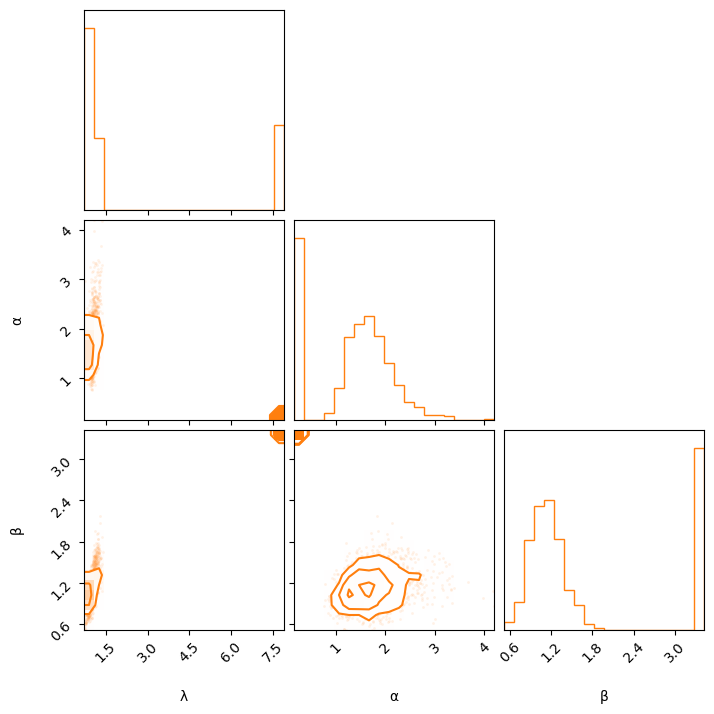

local_gaussian_ii
0.005


Sampling stage: Adaptive warm up [1:14:09] > Main non-adaptive [1:17:22]

Chain 1/4: 100%|██████████|500/500 [19:22<00:00, 2.32s/it, n_step=1.02e+03, accept_stat=0.861]

Chain 2/4: 100%|██████████|500/500 [19:21<00:00, 2.32s/it, n_step=1.02e+03, accept_stat=0.857]

Chain 3/4: 100%|██████████|500/500 [19:24<00:00, 2.33s/it, n_step=1.02e+03, accept_stat=0.862]

Chain 4/4: 100%|██████████|500/500 [19:14<00:00, 2.31s/it, n_step=1.02e+03, accept_stat=0.861]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,1.016,0.106,0.802,1.202,0.004,0.003,863.0,1403.0,1.0
α,1.698,0.427,0.921,2.495,0.014,0.010,878.0,1123.0,1.0
β,1.131,0.249,0.626,1.577,0.008,0.006,1001.0,1248.0,1.0


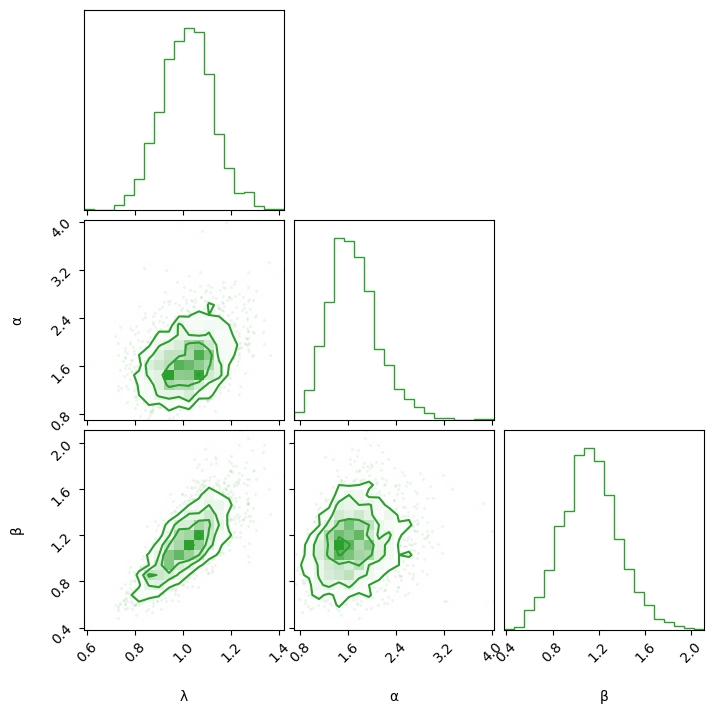

In [28]:
n_chain = 4
n_warm_up_iter = 500
n_main_iter = 500
dt_inference_seq = np.array([0.02, 0.01, 0.005]) 
trace = [[] for i in range(2)]

for dt_inference in dt_inference_seq:
    color = 1
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 0.1,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20230227)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            color=f'C{color}',
        )
        display(summary)
        display(fig)
        plt.close(fig)
        trace[color-1].append(traces)
        color += 1
